In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import warnings
warnings.filterwarnings('ignore')

<HDF5 file "Cadherin_s3.h5" (mode r)>


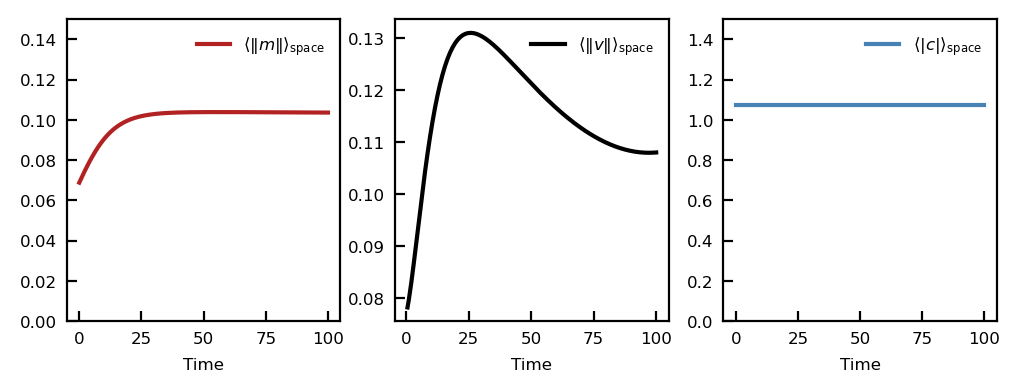

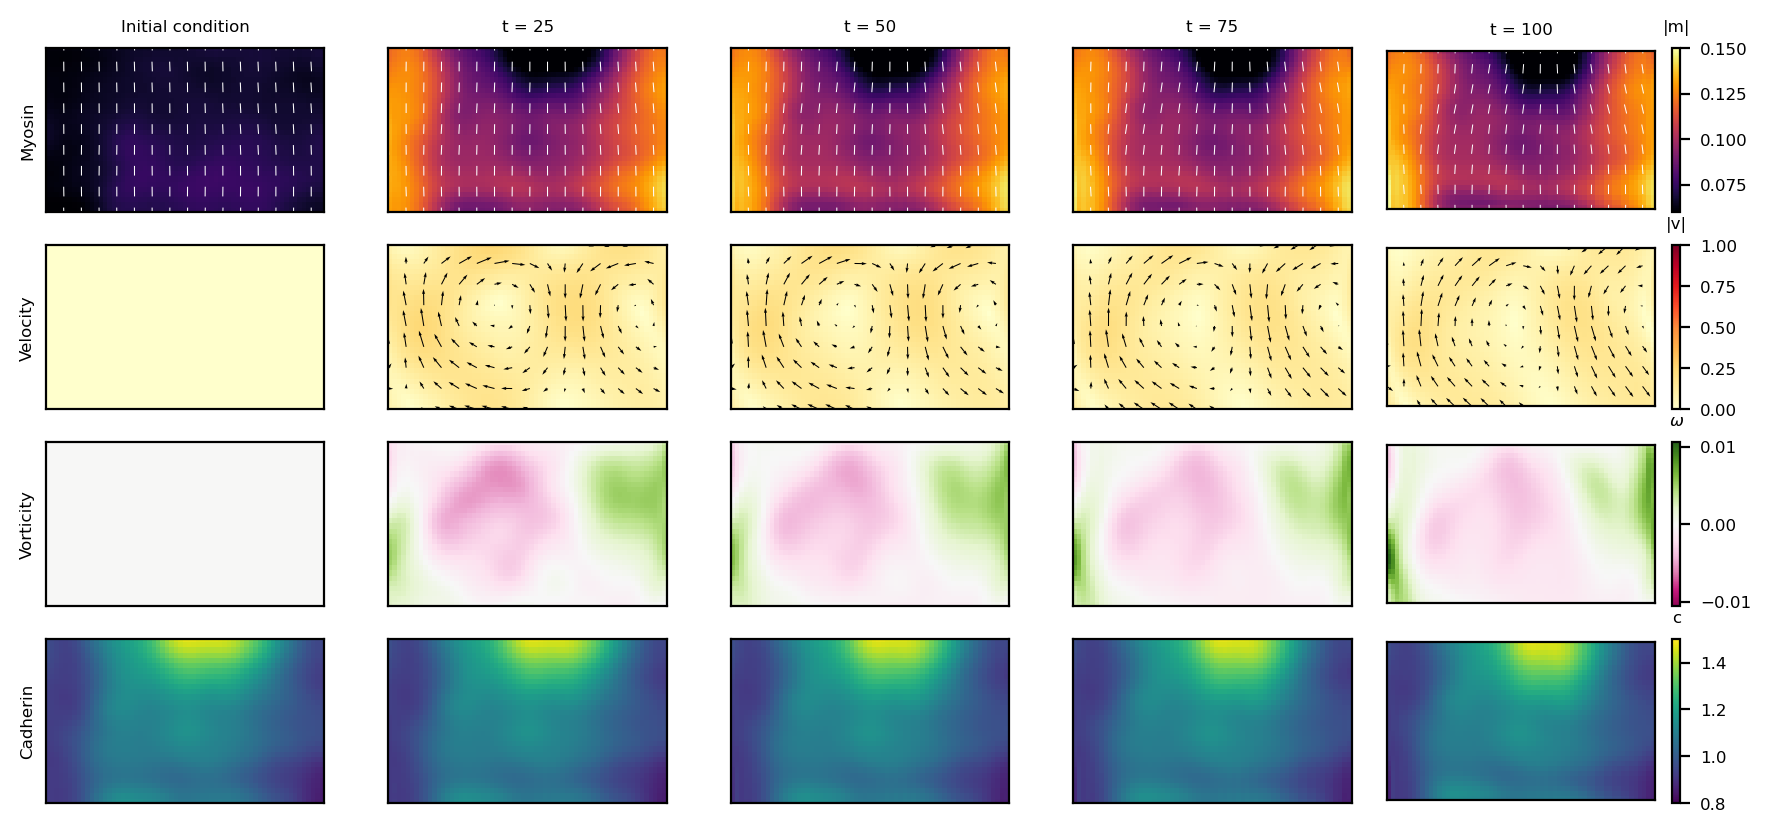

In [51]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 6

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

def plot_all(h5f, slc=slice(None, None), dt=10, 
             mmin=0.06, mmax=0.15, 
             vmin=0, vmax=3, 
             cmin=0.8, cmax=1.5, 
             skip=4, half=True):
    #Collect data
    print(h5f)
    mij = h5f['tasks/m'][slc]
    vi  = h5f['tasks/v'][slc]
    c   = h5f['tasks/c'][slc]
    t0  = h5f['scales/sim_time'][slc]
  
    fig1, ax = plt.subplots(1, 3, dpi=200, figsize=(6, 2))
    ax[0].plot(t0, np.mean(np.linalg.norm(mij, axis=(1, 2)), axis=(1, 2)), 
                   color='firebrick', label=r"$\langle|\!|m|\!|\rangle_{{\rm space}}$")    
    ax[1].plot(t0[1:], np.mean(np.linalg.norm(vi[1:], axis=(1)), axis=(1, 2)),
                   color='black', label=r"$\langle|\!|v|\!|\rangle_{{\rm space}}$")
    ax[2].plot(t0, np.mean(c, axis=(1, 2)),
                   color='steelblue', label=r"$\langle|c|\rangle_{{\rm space}}$")
    for a in ax:
        a.set_xlabel('Time')
        a.tick_params(which='both', direction='in')
        a.legend(framealpha=False)
    ax[0].set_ylim([0, mmax])
    #ax[1].set_ylim([0, vmax])
    ax[2].set_ylim([0, 1.5])
        
    mij = mij[::dt]
    vi  = vi[::dt]
    c   = c[::dt]
    t0  = t0[::dt]
    
    x = np.linspace(0, h5f['params/Lx'], mij.shape[-2])
    y = np.linspace(0, h5f['params/Ly'], mij.shape[-1])  
    w = mij.shape[0] * 2 + 1
    fig2, ax = plt.subplots(4, mij.shape[0], dpi=200, figsize=(w, 5.) if half else (w, 10))
    
    wi = np.gradient(vi[:, 1], x, axis=-2) - np.gradient(vi[:, 0], y, axis=-1)
    wmax = max(abs(np.min(wi)), np.max(wi))
        
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    
    for i, (mi, v, w, ci) in enumerate(zip(mij, vi, wi, c)):
        m, n = get_director_magnitude(mi)
        ax[0, i].set_title(f't = {t0[i]:g}')
        pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=mmin, vmax=mmax)
        ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
        
        pcV = ax[1, i].pcolormesh(x, y, np.linalg.norm(v, axis=0).T, vmin=vmin, vmax=vmax, cmap='YlOrRd')
        ax[1, i].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, color="black")
        pcW = ax[2, i].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-wmax, vmax=wmax)
        
        pcC = ax[3, i].pcolormesh(x, y, ci.T, vmin=cmin, vmax=cmax, cmap='viridis')
    
    plt.colorbar(pcM, ax=ax[0, i]).ax.set_title("|m|")    
    plt.colorbar(pcV, ax=ax[1, i]).ax.set_title("|v|")
    plt.colorbar(pcW, ax=ax[2, i]).ax.set_title('$\\omega$')
    plt.colorbar(pcC, ax=ax[3, i]).ax.set_title('c')

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')
        if half:
            a.set_ylim([0, a.get_ylim()[1]/2])
    ax[0, 0].set_title('Initial condition')
    
    ax[0, 0].set_ylabel('Myosin')
    ax[1, 0].set_ylabel('Velocity')
    ax[2, 0].set_ylabel('Vorticity')
    ax[3, 0].set_ylabel('Cadherin')
        
    fig2.subplots_adjust(wspace=0.02)
    
    return fig1, fig2
    
name = 'Cadherin_s3'
folder = name.split('_')[0]

slc = slice(0, None)
dt = 50

with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    fig1, fig2 = plot_all(h5f, slc, dt, vmax=1, half=True)
    fig1.savefig(f'dedalus_runs/{folder}/{name}_trajectory.png', bbox_inches='tight')
    fig2.savefig(f'dedalus_runs/{folder}/{name}_images.png', bbox_inches='tight')